在目标检测领域并没有类似MNIST或Fashion-MNIST那样的小数据集。为了快速测试模型，我们合成了一个小的数据集。我们首先使用一个开源的皮卡丘3D模型生成了1000张不同角度和大小的皮卡丘图像。然后我们收集了一系列背景图像，并在每张图的随机位置放置一张随机的皮卡丘图像。该数据集使用MXNet提供的im2rec工具将图像转换成了二进制的RecordIO格式。该格式既可以降低数据集在磁盘上的存储开销，又能提高读取效率。如果想了解更多的图像读取方法，可以查阅GluonCV工具包的文档。

# 下载数据集
前面说了，皮卡丘数据集使用MXNet提供的im2rec工具将图像转换成了二进制的RecordIO格式，但是我们后续要使用PyTorch，所以我先用[脚本](https://github.com/ShusenTang/Dive-into-DL-PyTorch/blob/master/code/chapter09_computer-vision/9.6.0_prepare_pikachu.ipynb)将其转换成了PNG图片并用json文件存放对应的label信息。在继续阅读前，请务必确保运行了这个脚本，保证数据已准备好。`pikachu`文件夹下的结构应如下所示。

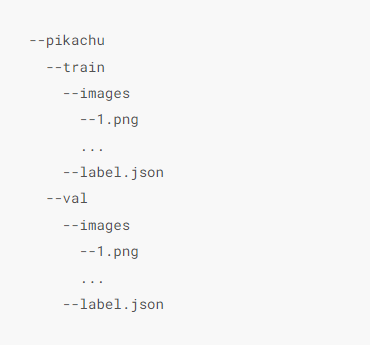

先导入相关库。

In [1]:
%matplotlib inline
import os
import json
import numpy as np
import torch
import torchvision
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

# data_dir = '../Datasets/pikachu'
data_dir = '../Datasets/pikachu'

assert os.path.exists(os.path.join(data_dir, "train"))

# 读取数据集
我们先定义一个数据集类`PikachuDetDataset`，数据集每个样本包含`label`和`image`，其中`label`是一个 `m×5` 的向量，即m个边界框，每个边界框由`[class, x_min, y_min, x_max, y_max]`表示，这里的皮卡丘数据集中每个图像只有一个边界框，因此m=1。`image`是一个所有元素都位于[0.0, 1.0]的浮点`tensor`，代表图片数据。

In [2]:
# 本类已保存在d2lzh_pytorch包中方便以后使用
class PikachuDetDataset(torch.utils.data.Dataset):
    """皮卡丘检测数据集类"""
    def __init__(self, data_dir, part, image_size=(256, 256)):
        assert part in ["train", "val"]
        self.image_size = image_size
        self.image_dir = os.path.join(data_dir, part, "images")

        with open(os.path.join(data_dir, part, "label.json")) as f:
            self.label = json.load(f)

        self.transform = torchvision.transforms.Compose([
            # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
            torchvision.transforms.ToTensor()])

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        image_path = str(index + 1) + ".png"

        cls = self.label[image_path]["class"]
        label = np.array([cls] + self.label[image_path]["loc"], 
                         dtype="float32")[None, :]

        PIL_img = Image.open(os.path.join(self.image_dir, image_path)
                            ).convert('RGB').resize(self.image_size)
        img = self.transform(PIL_img)

        sample = {
            "label": label, # shape: (1, 5) [class, xmin, ymin, xmax, ymax]
            "image": img    # shape: (3, *image_size)
        }

        return sample

然后我们通过创建`DataLoader`实例来读取目标检测数据集。我们将以随机顺序读取训练数据集，按序读取测试数据集。

In [3]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def load_data_pikachu(batch_size, edge_size=256, data_dir = '../Datasets/pikachu'):  
    """edge_size：输出图像的宽和高"""
    image_size = (edge_size, edge_size)
    train_dataset = PikachuDetDataset(data_dir, 'train', image_size)
    val_dataset = PikachuDetDataset(data_dir, 'val', image_size)


    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=0)

    val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=0)
    return train_iter, val_iter

下面我们读取一个小批量并打印图像和标签的形状。图像的形状和之前实验中的一样，依然是(批量大小, 通道数, 高, 宽)。而标签的形状则是(批量大小, m, 5)，其中m等于数据集中单个图像最多含有的边界框个数。小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。由于每张图像含有的边界框个数可能不同，我们为边界框个数小于m的图像填充非法边界框，直到每张图像均含有m个边界框。这样，我们就可以每次读取小批量的图像了。图像中每个边界框的标签由长度为5的数组表示。数组中第一个元素是边界框所含目标的类别。当值为-1时，该边界框为填充用的非法边界框。数组的剩余4个元素分别表示边界框左上角的x和y轴坐标以及右下角的x和y轴坐标（值域在0到1之间）。这里的皮卡丘数据集中每个图像只有一个边界框，因此m=1。

In [4]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size, data_dir)
batch = iter(train_iter).next()
print(batch["image"].shape, batch["label"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


# 图示数据
我们画出10张图像和它们中的边界框。可以看到，皮卡丘的角度、大小和位置在每张图像中都不一样。当然，这是一个简单的人工数据集。实际中的数据通常会复杂得多。

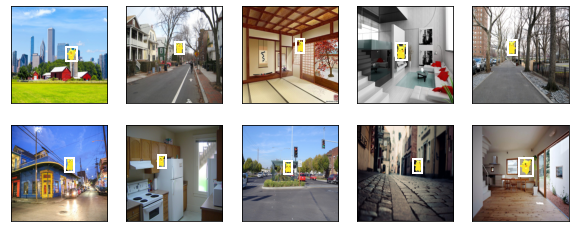

In [5]:
imgs = batch["image"][0:10].permute(0, 2, 3, 1)
bboxes = batch["label"][0:10, 0, 1:]

axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    d2l.show_bboxes(ax, [bb * edge_size], colors=['w'])

# 小结
+ 合成的皮卡丘数据集可用于测试目标检测模型。
+ 目标检测的数据读取跟图像分类的类似。然而，在引入边界框后，标签形状和图像增广（如随机裁剪）发生了变化。